In [1]:
import tensorflow as tf
#tf.reset_default_graph()

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU, LeakyReLU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import itertools
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
import tensorflow.contrib.slim as slim

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
def find_anomolies(idx):
    arr = data_x[idx, :, :, :, :]
    diffs = []
    for i in range(0, 24):
        mins, maxs = (np.min(arr[i, :, :, 1]), np.max(arr[i, :, :, 1]))
        diff = (maxs - mins)
        diffs.append(diff)
    print(np.min(diffs)/np.max(diffs))

In [4]:
%run ../src/zoneout.py
%run ../src/convgru.py
%run ../src/lovasz.py
%run ../src/utils.py
%run ../src/adabound.py

In [5]:
df = pd.read_csv("../data/subplot.csv")
df1 = pd.read_csv("../data/subplot2.csv")
df2 = pd.read_csv("../data/subplot3.csv")
df3 = pd.read_csv("../data/subplot4.csv")

df = df.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df1 = df1.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df2 = df2.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df3 = df3.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)

lens = [len(x) for x in [df, df1, df2, df3]]

df = pd.concat([df, df1, df2, df3], ignore_index = True)
df = df.dropna(axis = 0)

existing = [int(x[:-4]) for x in os.listdir('../data/shifted/') if ".DS" not in x]

df = df[df['PLOT_ID'].isin(existing)]
N_SAMPLES = int(df.shape[0]/196)
print(N_SAMPLES)

plot_ids = sorted(df['PLOT_ID'].unique())

def reconstruct_images(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

data = [reconstruct_images(x) for x in plot_ids]

# Initiate empty lists to store the X and Y data in
data_x, data_y, lengths = [], [], []

# Iterate over each plot
pad = True
flip = False
for i in plot_ids:
    # Load the sentinel imagery
    x = np.load("../data/shifted/" + str(i) + ".npy")
    x = x[0, :, :, :, :]
    # Shape check
    x = ndvi(x, image_size = 16)
    x = evi(x, image_size = 16)
    x = savi(x, image_size = 16)
    x = remove_blank_steps(x)
    x_grad, y_grad = np.gradient(np.reshape(x[0, :, :, 10], (16, 16)))
        #x[:, :, :, 10] = (x[:, :, :, 10] - np.min(x[:, :, :, 10]) / np.max(x[:, :, :, 10])
    mag = np.stack([np.reshape(np.sqrt(x_grad**2 + y_grad**2)*10, (16, 16, 1))]*x.shape[0])
        #if np.max(mag) > 0:
        #    mag = (mag - np.min(mag)) / np.max(mag)
    x = np.concatenate([x, mag], axis = -1)
    x = x[:, :, :, [x for x in range(0, 15) if x != 10]]
    #x = np.clip(x, 0, 1)
    print(x.shape[0])
    y = reconstruct_images(i)
    lengths.append(x.shape[0])
    if pad:
        if x.shape[0] < 24:
            padding = np.zeros((24 - x.shape[0], IMAGE_SIZE, IMAGE_SIZE, 13))
            x = np.concatenate((x, padding), axis = 0)
    data_x.append(x)
    data_y.append(y)
    if flip:
            # FLIP HORIZONTAL
        x1 = np.flip(x, 1)
        data_x.append(x1)
        data_y.append(np.flip(y, 0))
        lengths.append(x.shape[0])

            # FLIP BOTH
        x2 = np.flip(x, 2)
        x2 = np.flip(x2, 1)
        data_x.append(x2)
        data_y.append(np.flip(y, [0, 1]))
        lengths.append(x.shape[0])
            # FLIP VERTICAL
        x3 = np.flip(x, 2)
        data_x.append(x3)
        data_y.append(np.flip(y, 1))
        lengths.append(x.shape[0])

data_x = np.stack(data_x)
data_y = np.stack(data_y)
data_y = np.reshape(data_y, (N_SAMPLES, 14, 14, 1))
lengths = np.stack(lengths)
lengths = np.reshape(lengths, (lengths.shape[0], 1))

print("Finished data loading")
print(data_y.shape)

672
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24


In [6]:
ZONE_OUT_PROB = 0.1 #(0.05, 0.20, 0.05) --> 4
L2_REG = 0.001 #(1-e6, 1-e1, x10) --> 5
INITIAL_LR = 2e-5 #(1e-6, 1e-3, x5) --> 10
FINAL_LR = 2e-3 # (1e - 5, 1e-2, x5) --> 10
LOSS_WEIGHTING = 0.5 #(0.2, 1, 0.2) --> 5
SQUEEZE_RATIO = 4 # --> 4, 8, 12, 16 --> 4
BN_MOMENTUM = 0.9 # --> 3
N_LAYERS = 4 # --> 3
REG_TYPE = 'kernel' # kernel # --> 2
SQUEEZE = True
LAYER_NORM = True 
BATCH_SIZE = 4 # -->4
LOSS_TYPE = 'bce-jaccard' #bce-jaccard, bce-dice, bce-lovasz, focal-jaccard, etc. --> 4
N_CONV_PER_LAYER = 1 # --> 2
ACTIVATION_TYPE = 'ELU' #RELU, PRELU --> 2
MASK_LOSS = False # --> 2
PAD_INPUT_TYPE = 'none' # zero, reflect, none # --> 2
RENORM_CLIPPING = None # --> 5
FRESH_START = False
TRAIN_RATIO = 0.75
TEST_RATIO = 0.25


AUGMENTATION_RATIO = 4
IMAGE_SIZE = 16
N_SAMPLES = 679
RESIZE_OUTPUT = False

LABEL_SIZE = 14
#if LABEL_SIZE == 16 and not RESIZE_OUTPUT:
#    LABEL_SIZE = IMAGE_SIZE
    
TRAIN_SAMPLES = int((N_SAMPLES * AUGMENTATION_RATIO) * TRAIN_RATIO)
TEST_SAMPLES = int((N_SAMPLES * AUGMENTATION_RATIO) - TRAIN_SAMPLES)
print(TRAIN_SAMPLES // AUGMENTATION_RATIO, N_SAMPLES - (TRAIN_SAMPLES // AUGMENTATION_RATIO))

509 170


In [7]:
import tensorflow.contrib.slim as slim
import numpy as np
import os
from tensorflow.contrib.slim import conv2d

def cse_block(prevlayer, prefix):
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    # Bug? Should be 1 here?
    conv = Conv2D(K.int_shape(prevlayer)[3], (1, 1), padding="same", kernel_initializer="he_normal",
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''
    Implementation of Concurrent Spatial and Channel ‘Squeeze & Excitation’ in Fully Convolutional Networks
    https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    x = Add(name=prefix + "_csse_mul")([cse, sse])

    return x



def Batch_Normalization(x, training, scope):
    return batch_normalization(inputs=x, 
                               momentum = BN_MOMENTUM, 
                               training=training,
                               renorm = True,
                               reuse=None,
                               name = scope)

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

def conv_bn_elu(inp, is_training, kernel_size, scope, filter_count = 16):
    if kernel_size == 3:
        padded = ReflectionPadding2D((1, 1,))(inp)
        padding = 'valid'
    else:
        padded = inp
        padding = 'same'
    conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size),
                      padding = padding, kernel_regularizer=reg)(padded)
    elu = ELU()(conv)
    bn = Batch_Normalization(elu, training=is_training, scope = scope + "bn")
    return bn
    
def fpa(inp, filter_count):
    one = conv_bn_elu(inp, is_training, 1, 'forward1', filter_count)
    three = conv_bn_elu(inp, is_training, 3, 'down1', filter_count)
    #three_f = conv_bn_elu(three, is_training, 3, 'down1_f', filter_count)
    two = conv_bn_elu(three, is_training, 2, 'down2', filter_count)
    #two_f = conv_bn_elu(two, is_training, 2, 'down2_f', filter_count)
    
    # top block
    pooled = tf.keras.layers.GlobalAveragePooling2D()(inp)
    one_top = conv_bn_elu(tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])), is_training, 1, 'top1', filter_count)
    four_top = tf.keras.layers.UpSampling2D((4, 4))(one_top)
    
    
    concat_1 = tf.multiply(one, tf.add(three, two))
    concat_2 = tf.add(concat_1, four_top)
    print("Feature pyramid attention shape {}".format(concat_2.shape))
    return concat_2

def upconv2d(X, filters, is_training, scope):
    X = tf.image.resize_images(X, [X.shape[1]*2, X.shape[2]*2],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    X = conv_bn_elu(X, is_training, 3, scope, filter_count = filters)
    return X

    
def create_deconv_init(filter_size, num_channels):
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x,y] = (1 - abs(x - center) / scale_factor) * \
                                   (1 - abs(y - center) / scale_factor)
    weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        weights[:, :, i, i] = bilinear_kernel

    #assign numpy array to constant_initalizer and pass to get_variable
    bilinear_init = tf.constant_initializer(value=weights, dtype=tf.float32)
    return bilinear_init

def get_deconv2d(inp, filter_count, num_channels, scope, is_training):
    bilinear_init = create_deconv_init(4, filter_count)
    x = tf.keras.layers.Conv2DTranspose(filters = filter_count, kernel_size = (4, 4),
                                             strides=(2, 2), padding='same', kernel_initializer = bilinear_init)(inp)
    x = ELU()(x)
    x = Batch_Normalization(x, training=is_training, scope = scope + "bn")
    return x
    

def gau(x_low_level, x_high_level, scope, is_training, filter_count, uptype, size = 4):
    """
    The global attention upsample to replace the up_cat_conv element
    """
    low_feat = conv_bn_elu(x_low_level, is_training, 3, 'gauforward' + scope, filter_count)
    high_gap = tf.keras.layers.GlobalAveragePooling2D()(x_high_level)
    high_feat = tf.keras.layers.Reshape((1, 1, -1))(high_gap)
    high_feat_gate = tf.keras.layers.UpSampling2D((size, size))(high_feat)
    gated_low = tf.keras.layers.multiply([low_feat, high_feat_gate])
    gated_low = conv_bn_elu(gated_low, is_training, 3, 'gauforward5' + scope, filter_count)
    if uptype == "upconv":
        gated_high = upconv2d(gated_low, filter_count, is_training, scope)
    elif uptype == "transpose":
        bilinear_init = create_deconv_init(4, filter_count)
        gated_high = tf.keras.layers.Conv2DTranspose(filters = filter_count, kernel_size = (4, 4),
                                             strides=(2, 2), padding='same', kernel_initializer = bilinear_init)(gated_low)
        gated_high = ELU()(gated_high)
        gated_high = Batch_Normalization(gated_high, training=is_training, scope = scope + "bn")
    high_clamped = conv_bn_elu(x_high_level, is_training, 3, 'gauforward1' + scope, filter_count)
    return tf.keras.layers.add([gated_high, high_clamped])

In [8]:
reg = keras.regularizers.l2(L2_REG)
inp = tf.placeholder(tf.float32, shape=(None, 24, IMAGE_SIZE, IMAGE_SIZE, 14))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
length2 = tf.reshape(length, (-1,))
is_training = tf.placeholder_with_default(False, (), 'is_training')

weights = tf.ones([14, 14], tf.float32)
weights = tf.pad(weights, [[1, 1], [1, 1]], 'constant')
weights = tf.reshape(weights, (16*16,)) 

reg = keras.regularizers.l2(L2_REG)
inp = tf.placeholder(tf.float32, shape=(None, 24, IMAGE_SIZE, IMAGE_SIZE, 14))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
alpha = tf.placeholder(tf.float32, shape = (None))



length2 = tf.reshape(length, (-1,))
is_training = tf.placeholder_with_default(False, (), 'is_training')
power = tf.placeholder_with_default(1.0, (), 'power')

if PAD_INPUT_TYPE == 'zero':
    inp_pad = tf.pad(inp, [[0, 0], [0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")

if PAD_INPUT_TYPE == 'reflect':
    inp_pad = tf.pad(inp, [[0, 0], [0, 0], [1,1], [1,1], [0,0] ], 'REFLECT')
    
if PAD_INPUT_TYPE == 'none':
    inp_pad = inp
    
FILTER_SIZE = LABEL_SIZE if RESIZE_OUTPUT else IMAGE_SIZE

down_16 = 8
down_8 = 32
down_4f = 44
#down_2f = 2
#up_4 = 30
up_8 = 32
up_16 = 16

def down_block(inp, length, size, flt, scope, train):
    with tf.variable_scope(scope):
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'SAME')
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'SAME')
        cell_fw = ZoneoutWrapper(
            cell_fw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        gru = convGRU(inp, cell_fw, cell_bw, length)
        down = TimeDistributed(MaxPool2D(pool_size = (2, 2)))(gru[0])
        print("Down block shape: {}".format(gru[1].shape))
    return down, gru[1]

def down_block_no_gru(inp, flt, scope, train):
    with tf.variable_scope(scope):
        padded = ReflectionPadding2D((1, 1))(inp)
        
        # Conv block 1
        conv = Conv2D(filters = flt, kernel_size = (3, 3),
                      padding = 'valid', kernel_regularizer=reg)(padded)
        elu = ELU()(conv)
        bn = Batch_Normalization(elu, training=is_training, scope = scope + "bn")
        x = csse_block(bn, prefix='csse_block_{}'.format(scope))
        down = MaxPool2D(pool_size = (2, 2))(x)
        print("Down block shape: {}".format(down.shape))
    return down


def up_block(inp, concat_inp, flt, sq, scope, concat, is_training, uptype, padding = True):
    with tf.variable_scope(scope):
        
        gau_layer = gau(inp, concat_inp, scope, is_training, flt, uptype, inp.shape[-2])
        x = csse_block(gau_layer, prefix='csse_block_{}'.format(scope))
        print("Up block conv 1 shape: {}".format(x.shape))
        return x
        
        
down_1, copy_1 = down_block(inp_pad, length2, [FILTER_SIZE, FILTER_SIZE], down_16, 'down_16', is_training)
down_2 = down_block_no_gru(copy_1, down_8, 'down_8', is_training)
down_3 = down_block_no_gru(down_2, down_4f, 'down_4', is_training)

down_fpa = fpa(down_3, down_4f)
up_3 = up_block(down_fpa, down_2, up_8, up_8, 'up_8', True, is_training, "transpose", padding =  True, ) # 4 - 8
up_2 = up_block(up_3, copy_1, up_16, up_16, 'up_16', True, is_training, "transpose", padding = True) # 8 - 16

#
up_4_16 = get_deconv2d(down_2, down_8, up_8, "upfinal1", is_training)
up_8_16 = get_deconv2d(up_3, up_8, up_16, 'upfinal2', is_training)        
concat_final = tf.concat([up_2, up_4_16, up_8_16], axis = -1)
up_2 = Conv2D(filters = 24, kernel_size = (3, 3), padding = 'valid')(concat_final)
elu = ELU()(up_2)
bn = Batch_Normalization(elu, training=is_training, scope = "out1bn")
#x = csse_block(elu, prefix='csse_block_{}'.format("out1"))

x = Conv2D(filters = 24, kernel_size = (3, 3), padding = 'valid')(bn)

#up_2 = Conv2D(filters = 20, kernel_size = (3, 3), padding = 'valid', kernel_regularizer=reg)(x)
#elu = ELU()(up_2)

#B = tf.Variable([-np.log(0.99/0.01)]) 
init = tf.constant_initializer([-np.log(0.98/0.02)])
fm = Conv2D(filters = 1,
            kernel_size = (1, 1), 
            padding = 'valid',
            activation = 'sigmoid',
            #bias_initializer = init,
            )(x)
print(fm.shape)

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Down block shape: (?, 16, 16, 16)
Instructions for updating:
Use keras.layers.batch_normalization instead.
Down block shape: (?, 8, 8, 32)
Down block shape: (?, 4, 4, 44)
Feature pyramid attention shape (?, 4, 4, 44)
Up block conv 1 shape: (?, 8, 8, 32)
Up block conv 1 shape: (?, 16, 16, 16)
(?, 12, 12, 1)


In [14]:
#weight = np.full((len(data_x), 9), 1/9)
weight = np.zeros((len(data_x), 9))
for i in range(weight.shape[0]):
    weight[i, 0] = 1.
    #weight[i, np.random.randint(0, 9)] = 1.
#weight = np.load("weights.npy")

In [15]:
weight

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [16]:
def calc_alignment(true, pred):
    wt = []
    for i in range(BATCH_SIZE):
        clipped_tensor = [true[i, 1:13, 1:13],
                         true[i, 0:12, 1:13],
                         true[i, 2:14, 1:13],
                         true[i, 1:13, 0:12],
                         true[i, 1:13, 2:14],
                         true[i, 2:14, 0:12],
                         true[i, 0:12, 0:12],
                         true[i, 2:14, 2:14],
                         true[i, 0:12, 2:14]]
        
        pred_i = pred[i, :, :, :]
        
        clipped_ces = tf.stack([binary_crossentropy(tf.reshape(x, (12, 12, 1)), pred_i) for x in clipped_tensor])
        clipped_ces = tf.reduce_mean(clipped_ces, axis = [1,2])

        clipped_ces = tf.reshape(clipped_ces, (-1, 9))
        clipped_ces = clipped_ces# - tf.reduce_mean(clipped_ces)
        wt.append(clipped_ces)
    print("WT CONCAT", tf.squeeze(tf.stack(wt), axis = 1).shape)
    return tf.squeeze(tf.stack(wt, axis =1))

def loss_fn(true, pred, weights):
    print(weights)
    ce = []
    for i in range(BATCH_SIZE):
        weights_i = weights[i, :]
        clipped_tensor = [true[i, 1:13, 1:13],
                         true[i, 0:12, 1:13],
                         true[i, 2:14, 1:13],
                         true[i, 1:13, 0:12],
                         true[i, 1:13, 2:14],
                         true[i, 2:14, 0:12],
                         true[i, 0:12, 0:12],
                         true[i, 2:14, 2:14],
                         true[i, 0:12, 2:14]]
    
        clipped_ces = [binary_crossentropy(tf.reshape(x, (-1, 12, 12, 1)), tf.reshape(pred[i, :, :], (1, 12, 12, 1))) for x in clipped_tensor]
        clipped_ces = tf.stack(clipped_ces)
        clipped_ces = tf.reshape(clipped_ces, (1, 9, 12, 12))
        #weights_i = tf.stack([weights_i] * 12*12)
        loss = clipped_ces * tf.reshape(weights_i, (1, 9, 1, 1))
        loss = tf.reduce_sum(loss, axis = 1)
        ce.append(loss)
    ce = tf.reshape(tf.stack(ce), (BATCH_SIZE, 12, 12, 1))
    print("LOSS SHAPE", ce.shape)
    return ce

def loss_fn(true, pred, weights):
    losses = []
    for i in range(BATCH_SIZE):
        weights_i = weights[i, :]
        true_i = tf.reshape(true[i], (1, 14, 14, 1))
        pred_i = tf.reshape(pred[i], (1, 12, 12, 1))
        true_p = true_i
        #loss_o = binary_crossentropy(true_p, pred)
        # extract out the candidate shifts
        true_m = true_i[:, 1:13, 1:13]
        true_l = true_i[:, 0:12, 1:13]
        true_r = true_i[:, 2:14, 1:13]
        true_u = true_i[:, 1:13, 0:12]
        true_d = true_i[:, 1:13, 2:14]
        true_dr = true_i[:, 2:14, 0:12]
        true_dl = true_i[:, 0:12, 0:12]
        true_ur = true_i[:, 2:14, 2:14]
        true_ul = true_i[:, 0:12, 2:14]
        true_shifts = [true_m, true_l, true_r, true_u, true_d, true_dr, true_dl, true_ur, true_ul]
        bce_shifts = tf.stack([binary_crossentropy(x, pred_i) for x in true_shifts])
        loss = tf.reshape(bce_shifts, (1, 9, 12, 12)) * tf.reshape(weights_i, (1, 9, 1, 1))
        loss = tf.reduce_sum(loss, axis = 1)
        losses.append(loss)
    loss = tf.reshape(tf.stack(losses), (BATCH_SIZE, 12, 12, 1))
    return loss

In [17]:
np.set_printoptions(suppress=True)
BATCH_SIZE = 16
weights = tf.placeholder(tf.float32, shape=(None, 9))#, 1))
from tqdm import tqdm_notebook, tnrange
ids = [x for x in range(0, len(data_x))]

for total_step in range(0, 40):
    MODE = 'EXPECTATION'
    print("RUNNING A {} {} STEP".format(total_step, MODE))
    optimizer = tf.train.GradientDescentOptimizer(5e-6)
    weight_upd = calc_alignment(labels, fm)
    #loss = bce_shift(labels, fm, 1.5)
    loss = loss_fn(labels, fm, weights)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        optimizer = optimizer.minimize(loss)  

    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    orig = np.argmax(weight, axis = 1)
    # Run training loop
    for i in range(50):
        if i == 49:
            mode = 'MAXIMIZATION'
            print("RUNNING A {} {} STEP".format(total_step, MODE))
        losses = []

        for k in tnrange(int(len(ids) // BATCH_SIZE)):
            batch_ids = ids[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
            batch_y = data_y[batch_ids, :, :].reshape(BATCH_SIZE, 14, 14)
            op, tr, weight_update = sess.run([optimizer, loss, weight_upd],
                                              feed_dict={inp: data_x[batch_ids, :, :, :],
                                                         length: lengths[batch_ids],
                                                         labels: data_y[batch_ids, :, :].reshape(BATCH_SIZE, 14, 14),
                                                         is_training: True,
                                                         weights: weight[batch_ids],
                                                         })
            losses.append(tr)
            if k == 50:
                print(weight_update)
            if i == 49:
                #weight_update = np.clip(weight_update, -0.25, 0.25)
                #weight[batch_ids] -= weight_update
                weight[batch_ids] = weight_update
                #weight[batch_ids] = np.clip(weight[batch_ids], 0, 1)
                div = np.sum(weight[batch_ids], axis = 1)
                #print(div)
                #div = np.clip(div, 1, 10)
                weight[batch_ids] = weight[batch_ids] / div[:, np.newaxis]
        print("EPOCH {}: LOSS {}".format(i, np.mean(losses)))
    print('MEANS', np.mean(weight, axis = 0))
    print('MAXS', np.max(weight, axis = 0))
    diffs = [x for x, y in zip(np.argmax(weight, axis = 1), orig) if x != y]
    print("{} samples changed".format(len(diffs)))
    if MODE == 'maximization':
        weight = weight_update

RUNNING A 0 EXPECTATION STEP
WT CONCAT (16, 9)



EPOCH 0: LOSS 0.4754714071750641



EPOCH 1: LOSS 0.33973047137260437



EPOCH 2: LOSS 0.31933146715164185



EPOCH 3: LOSS 0.31053510308265686



EPOCH 4: LOSS 0.3049091398715973



EPOCH 5: LOSS 0.3030838072299957



EPOCH 6: LOSS 0.29818961024284363



EPOCH 7: LOSS 0.2962213158607483



EPOCH 8: LOSS 0.29499387741088867



EPOCH 9: LOSS 0.30258238315582275



EPOCH 10: LOSS 0.3153976500034332



EPOCH 11: LOSS 0.3092428147792816



EPOCH 12: LOSS 0.3023674488067627



EPOCH 13: LOSS 0.2917332649230957



EPOCH 14: LOSS 0.2978825867176056



EPOCH 15: LOSS 0.29510483145713806



EPOCH 16: LOSS 0.32266396284103394



EPOCH 17: LOSS 0.2939566969871521



EPOCH 18: LOSS 0.2968900799751282



EPOCH 19: LOSS 0.2847312092781067



EPOCH 20: LOSS 0.2825743556022644



EPOCH 21: LOSS 0.2796999216079712



EPOCH 22: LOSS 0.2818887233734131



EPOCH 23: LOSS 0.28522926568984985



EPOCH 24: LOSS 0.29130157828330994



EPOCH 25: LOSS 0.28895220160484314


KeyboardInterrupt: 

In [18]:
weight_update

array([[0.391956  , 0.38259098, 0.56062657, 0.5666053 , 0.396108  ,
        0.6800679 , 0.55190575, 0.5459731 , 0.39960805],
       [0.13759007, 0.13825016, 0.15357661, 0.12642668, 0.16201049,
        0.13980034, 0.12431583, 0.18228412, 0.16347381],
       [0.20386437, 0.2092442 , 0.1850372 , 0.25341082, 0.19302367,
        0.25554606, 0.2335638 , 0.15467122, 0.20803918],
       [0.27741238, 0.32971025, 0.35237202, 0.32516357, 0.35574353,
        0.42343676, 0.33833238, 0.3858012 , 0.41808817],
       [0.02224661, 0.02224661, 0.02224661, 0.02224661, 0.02224661,
        0.02224661, 0.02224661, 0.02224661, 0.02224661],
       [0.24029917, 0.2541683 , 0.24658097, 0.20816694, 0.2548617 ,
        0.22118714, 0.22390962, 0.26841748, 0.2621986 ],
       [0.04230591, 0.04230591, 0.04230591, 0.04230591, 0.04230591,
        0.04230591, 0.04230591, 0.04230591, 0.04230591],
       [0.26691633, 0.24148029, 0.41353002, 0.39917672, 0.33417284,
        0.48394358, 0.39206564, 0.45665348, 0.34024423],


In [22]:
#np.save("weights.npy", weight)


In [17]:
weight2 = np.load("weights.npy")

In [18]:
diffs = [x for x, y in zip(np.argmax(weight, axis = 1), np.argmax(weight2, axis = 1)) if x != y]

In [21]:
diffs

[5,
 1,
 2,
 5,
 2,
 7,
 6,
 3,
 1,
 3,
 0,
 6,
 6,
 6,
 0,
 8,
 5,
 3,
 8,
 1,
 2,
 6,
 5,
 2,
 1,
 6,
 8,
 1,
 1,
 3,
 3,
 6,
 8,
 1,
 6,
 6,
 0,
 6,
 1,
 3,
 8,
 3,
 5,
 6,
 1,
 6,
 5,
 2,
 1,
 6,
 2,
 0,
 2,
 0,
 6,
 6,
 6,
 6,
 0,
 2,
 3,
 6,
 1,
 2,
 8,
 8,
 8,
 7,
 0,
 0,
 1,
 4,
 3,
 1,
 3,
 4,
 1,
 0,
 2,
 7,
 4,
 5,
 4,
 4,
 6,
 4,
 7,
 3,
 3,
 4,
 6,
 1,
 5,
 4,
 0,
 0,
 0,
 1,
 8,
 2,
 1,
 8,
 4,
 3,
 8,
 0,
 1,
 0,
 5,
 3,
 7,
 1,
 7,
 6,
 6,
 4,
 0,
 2,
 6,
 3,
 1,
 1,
 5,
 4,
 0]

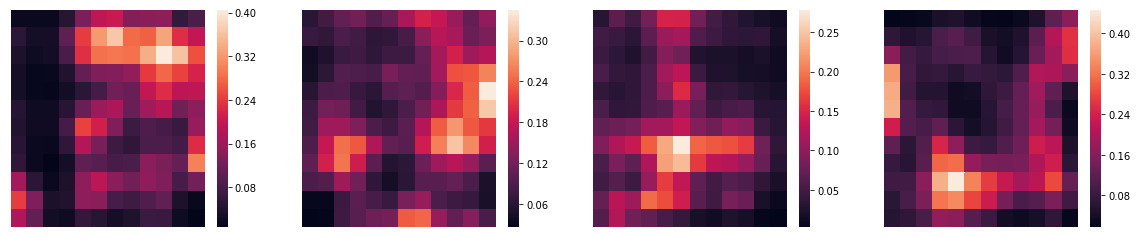

In [19]:
#TODO @jombrandt 
#TODO @jombrandt -- remove augmentation of val set
import random 

def multiplot(matrices):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i,matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], )
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])
    plt.show()
    
test_losses = []
matrix_ids = random.sample(ids, 4)
#matrix_ids = [988, 900, 2055, 444]
# 63""
preds = []
trues = []
for i in matrix_ids:
    idx = i
    y = sess.run([fm], feed_dict={inp: data_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, 14),
                                  length: lengths[idx].reshape(1, 1),
                                  is_training: False,
                                  labels: data_y[idx].reshape(1, 14, 14)
                                  })
    y = np.array(y).reshape(12, 12)
    if LABEL_SIZE == 16:
        y = y[1:15, 1:15]
    #y[np.where(y < 0.05)] = 0
    preds.append(y)
    true = data_y[idx].reshape(14, 14)

    trues.append(true)
    
multiplot(preds)

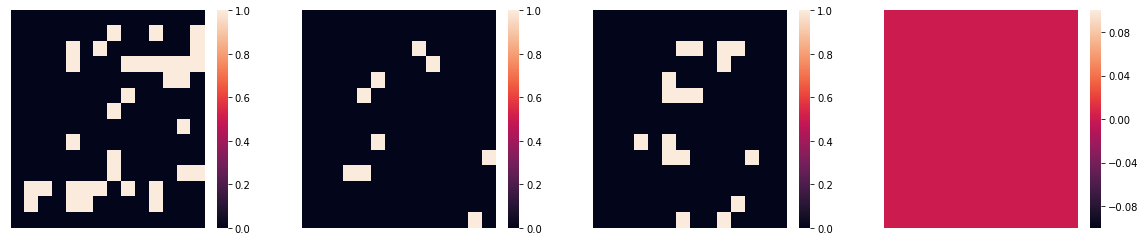

In [20]:
multiplot(trues)

In [15]:
weight[68:75]

array([[0.10038101, 0.        , 0.25865188, 0.        , 0.21697257,
        0.17307693, 0.        , 0.25091761, 0.        ],
       [0.07872518, 0.22697157, 0.        , 0.27978949, 0.        ,
        0.1220213 , 0.28531937, 0.        , 0.0071731 ],
       [0.09773434, 0.00424431, 0.17724928, 0.        , 0.26959614,
        0.        , 0.        , 0.30172839, 0.14944754],
       [0.47200323, 0.04005432, 0.06583271, 0.04901004, 0.18373267,
        0.        , 0.        , 0.18936704, 0.        ],
       [0.16465229, 0.01314757, 0.        , 0.        , 0.38835179,
        0.        , 0.        , 0.29093397, 0.14291438],
       [0.16666667, 0.        , 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        , 0.16666667, 0.        ],
       [0.03969682, 0.        , 0.31974922, 0.        , 0.08307043,
        0.21656611, 0.        , 0.34091742, 0.        ]])